# Asian Option Pricing using Monte Carlo

This report presents the results of using Monte Carlo (MC) to price an **Asian Call option** as given by the expected value of the discounted payoff function:

$V(S, t) = \mathbb{E}^\mathbb{Q} [e^{-\int^T_t rdr} \mathrm{Payoff}(S_T)] $


(for brevity, the results for a put option have been omitted).

## Initial parameters

The following parameters are used for the simulation, unless otherwise stated:

- Today's stock price S0 = 100
- Strike E = 100
- Time to expiry (T-t) = 1 year (100 time steps)
- Volatility = 20%
- Constant risk-free interest rate r = 5%


In [1]:
%matplotlib inline

%run ../SAsianOption.py
# Above line runs the following function 
# dic = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=100, k=10)

# Sets plot size in notebook
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)

EU V(T) = 10.0892013234
Asian AC_c(T) = 5.54659143575
Asian AC_d(T) = 5.49974029651
Asian GC_c(T) = 5.33383690461


## Stock Path Generation

We start by using MC to generate 100 stock price paths using the _Milstein_ convention. In this process we use the antithetic variance reduction technique which increases the statistics to compute the option price with minimal computational effort.

The below plot shows 100 of these paths:

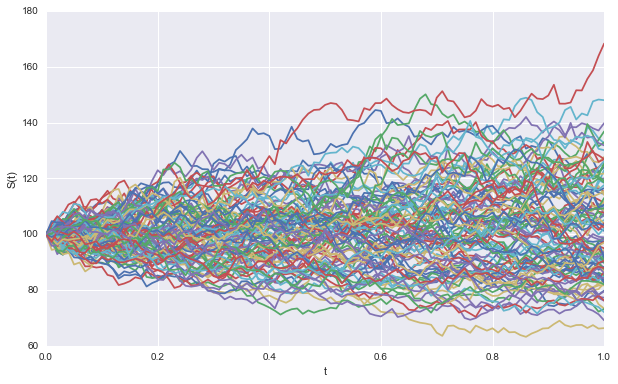

In [2]:
plt.plot(t_index, S_plus)
plt.ylabel("S(t)")
plt.xlabel("t")

## European Call Pricing

The same methodology is used to price a European Call option in order to compare to the Asian results later on. For the same input parameters above the following result is obtained:


In [3]:
print 'EU V(T) = {0}'.format(V)

EU V(T) = 10.0892013234


This yields the following Payoff plot at expiry (t=T), where the effect of the variance reduction technique is shown to boost the statistics to get a lower simulation error at little computing cost.

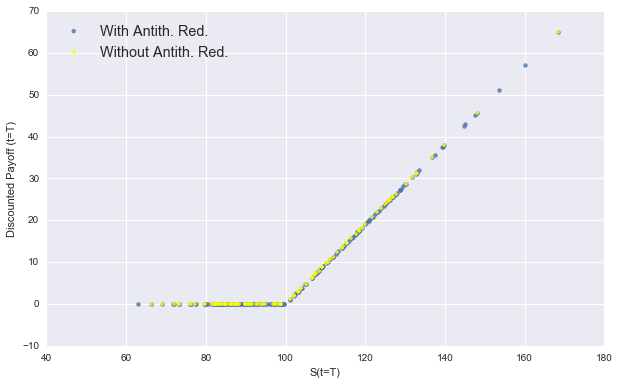

In [4]:
# V vs S plot without and with variance reduction
sns.regplot(x=S_join[-1], y=V_join[-1], fit_reg=False) # with antithetic correction
sns.regplot(x=S_plus[-1], y=V_plus[-1], fit_reg=False, color='yellow', marker='+') # without antithetic correction
plt.ylabel('Discounted Payoff (t=T)')
plt.xlabel('S(t=T)')
plt.legend(['With Antith. Red.', 'Without Antith. Red.'], loc='upper left', fontsize='large')

## Asian Call Pricing

The Asian Call value is then calculated using the same parameters above but with different methodologies to calculate the average of the stock price:

- **Arithmetic** averaging using **both continuous** ('AC_c') and **discrete** ('AC_d') sampling
- **Geometric** averaging using **continuous** sampling **only** ('GC_c')

Note in the context of MC, we refer to 'continous sampling' when all the data points available up to that time are used, whereas 'discrete sampling' uses a sample determined by sampling frequency k (10 days in this case).

For all the examples below a **fixed strike** is assumed.


### Continuous vs Discrete Sampling

First let's understand the effects of continuous vs discrete sampling. For this purpose we restrict to the Arithmetic case only and assume the Geometric case observes the same behaviour.

Plotting one of the simulated stock paths and correspondinge arithmetic continuous and discrete averages (using a sampling frequency of 10 days), we get the following:

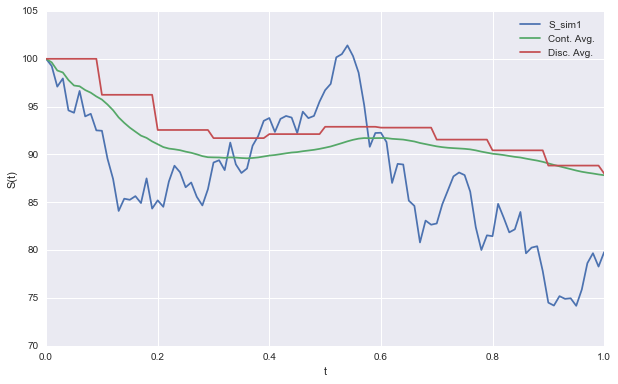

In [5]:
# S plot for MC, Arithmetic cont. and discrete averages
plt.plot(t_index, S_join[0:,0:1], label='S_sim1')
plt.plot(t_index, A_c_join[0:,0:1], label='Cont. Avg.')
plt.plot(t_index, A_d_join[0:,0:1], label='Disc. Avg.')
plt.ylabel('S(t)')
plt.xlabel('t')
plt.legend()


Hence we note that A_c and A_d differ slightly. This difference grows with the sampling frequency _k_ because for the same time to expiry we have less data points to calculate the average. This behaviour is show in the plot below where d_10 is more unstable than d_4, but as the number of data points increase, we expect the difference to get smaller and smaller, shown by the convergence trend close to expiry


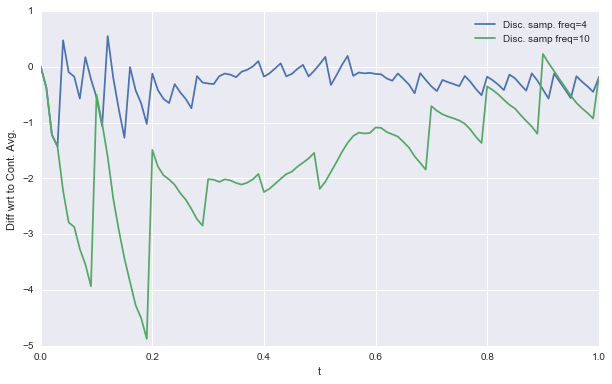

In [6]:
# Changing discrete sampling frequency from k=10 to k=4
dic2 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=100, k=4)

# Calculate differences wrt continous case
d_10 = A_c_join - A_d_join
d_4 = A_c_join - dic2['A_d_join']

# Plot for just one simulation
plt.plot(t_index, d_4[0:,0:1], label='Disc. samp. freq=4')
plt.plot(t_index, d_10[0:,0:1], label='Disc. samp freq=10')
plt.ylabel('Diff wrt to Cont. Avg.')
plt.xlabel('t')
plt.legend()

However, for practical and legal reasons path-dependent quantities are never measured continuously. There is minimum time step between sampling since it is difficult to incorporate every single traded price into an average, for example, data can be unreliable and the exact time of a trade may not be known accurately.  

The option price also evolves with number of time steps to expiry and whether the average is calculated discretely or continously, as shown in the below plot:

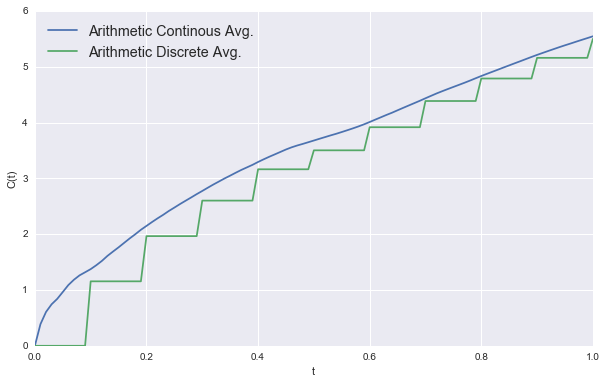

In [7]:
# Evolution of Asian Call value with number of time steps
c = AC_c_join.mean(axis=1)
d = AC_d_join.mean(axis=1)
plt.plot(t_index, c, label='Arithmetic Continous Avg.')
plt.plot(t_index, d, label='Arithmetic Discrete Avg.')
plt.ylabel('C(t)')
plt.xlabel('t')
plt.legend(loc='upper left', fontsize='large')

### Payoff function

The Payoff function at=T of the Asian call is also a lot more complex than it's European equivalent, which is expected given it's path-dependent nature. This justifies the need for using Monte Carlo methods for the pricing.

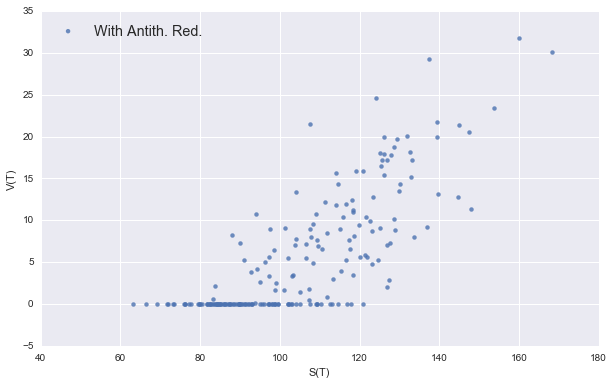

In [8]:
# # V vs S plot
sns.regplot(x=S_join[-1], y=AC_c_join[-1], fit_reg=False) # with antithetic correction
plt.ylabel('V(T)')
plt.xlabel('S(T)')
plt.legend(['With Antith. Red.'], loc='upper left', fontsize='large')

## Results and Errors

The results from varying the parameters in the model to study the effects on the pricing are presented now. The key for all below tables is the following:

- N_S: number of simulations
- V: European call equivalen
- AC_c: Arithmetic continous average Asian Call price
- AC_d: Arithmetic discrete average Asian Call price
- GC_c: Geometric continous average Asian Call price
- The error is represented in brackets next to the option values and is defined as the standard deviation of the estimate divided by the square root of the number of simulations  ($\mathrm{std}/ \sqrt{N}$)
- All the option values and errors are displayed to 6 significant figures

###  Varying the Number of Simulations

We see that as the number of simulations increases, the error in the estimate decreases (approximately by a factor of 10 every time the simulations increase by a factor of 10). Also note that the effect of the variance reduction technique is to effectively increase N_S by a factor of 2, which is why the error presented is smaller than for the N_S values shown. Run times weren't compared since the underlying python code for any of these cases takes less than 2 seconds and this was deemed quite acceptable.

In [9]:
df = pd.DataFrame(index=range(0,3))

# 100 simulations
fill_in_df(df, dic, 0)

# 1,000 simulations
dic_1k = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=1000, k=10)
fill_in_df(df, dic_1k, 1)

# 10,000 simulations
dic_10k = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df, dic_10k, 2)

df[['N_S', 'r', 'sigma', 'S0', 'K', 'Class', 'V', 'AC_c', 'AC_d', 'GC_c']]

,N_S,r,sigma,S0,K,Class,V,AC_c,AC_d,GC_c
0,100.0,0.05,0.2,100.0,100.0,ATM,10.089201 (0.131768),5.546591 (0.071872),5.499740 (0.071726),5.333837 (0.069442)
1,1000.0,0.05,0.2,100.0,100.0,ATM,10.610881 (0.015165),5.783801 (0.008124),5.707166 (0.008020),5.564119 (0.007840)
2,10000.0,0.05,0.2,100.0,100.0,ATM,10.388515 (0.001471),5.771337 (0.000798),5.685983 (0.000786),5.552812 (0.000770)


### Varying the Strike

In this case we see the following:

- ITM option is of course more expensive than OTM option for both the Asian and European Call
- The difference between the stock price (S0) and exercise price (K) has little effect on the estimate error (although there is perhaps a slight increase for ITM compared to ATM and OTM options)
- The methodology used to calculate the average of the stock (continous vs dicrete, arithmetic vs geometric) for the Asian option seems to have little effect in the error too
- The price of the European equivalent is always higher and by a consierable amount. However the difference (diff_GC_c) seems similar accross ITM, ATM and OTM (although this might not always hold depending on other parameters values - see ref)


In [10]:
df2 = pd.DataFrame(index=range(0,3))

# OTM, 10k simulations
dic_OTM = asian_option_simulator(S0=100., K=95., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df2, dic_OTM, 0)

# ATM, 10k simulations
df2.loc[1] = df.loc[2]

# ITM, 10k simulations
dic_ITM = asian_option_simulator(S0=100., K=105., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df2, dic_ITM, 2)

df2[['N_S', 'r', 'sigma', 'S0', 'K', 'Class', 'V', 'AC_c', 'AC_d', 'GC_c', 'diff_GC_c']]

,N_S,r,sigma,S0,K,Class,V,AC_c,AC_d,GC_c,diff_GC_c
0,10000.0,0.05,0.2,100.0,95.0,ITM,13.306567 (0.001611),8.825431 (0.000938),8.753649 (0.000925),8.575778 (0.000912),4.730789
1,10000.0,0.05,0.2,100.0,100.0,ATM,10.388515 (0.001471),5.771337 (0.000798),5.685983 (0.000786),5.552812 (0.000770),4.835703
2,10000.0,0.05,0.2,100.0,105.0,OTM,7.957399 (0.001319),3.514907 (0.000641),3.432210 (0.000630),3.330691 (0.000612),4.626708


### Varying the Volatility

The error appears to significantly increase when the volatility of the stock increases. This is expected since an increase in uncertainty in stock prices undermindes the predictability of the model itself. The incease in option price with volatility is also readily confirmed.

In [11]:
df3 = pd.DataFrame(index=range(0,3))

# Vol=20%
dic_vol30 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df3, dic_vol30, 0)

# Vol=30%
dic_vol30 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.3, M=100, I=10000, k=10)
fill_in_df(df3, dic_vol30, 1)

# Vol=40%
dic_vol40 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.4, M=100, I=10000, k=10)
fill_in_df(df3, dic_vol40, 2)

df3[['N_S', 'r', 'sigma', 'S0', 'K', 'Class', 'V', 'AC_c', 'AC_d', 'GC_c']]

,N_S,r,sigma,S0,K,Class,V,AC_c,AC_d,GC_c
0,10000.0,0.05,0.2,100.0,100.0,ATM,10.388515 (0.001471),5.771337 (0.000798),5.685983 (0.000786),5.552812 (0.000770)
1,10000.0,0.05,0.3,100.0,100.0,ATM,14.135187 (0.002251),7.961140 (0.001204),7.832518 (0.001187),7.507157 (0.001140)
2,10000.0,0.05,0.4,100.0,100.0,ATM,17.893775 (0.003127),10.158977 (0.001646),9.986547 (0.001624),9.379621 (0.001526)


### Varying the interest rate

In contrast to volatility, varying the interest rate has a negligible effect on the error. The increase in option value seems to be slower than that observed with volatility variation.

In [12]:
df4 = pd.DataFrame(index=range(0,3))

# r=3%
dic_r3 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.03, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df4, dic_r3, 0)

# r=5%
dic_r5 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df4, dic_r5, 1)

# r=7%
dic_r7 = asian_option_simulator(S0=100., K=100., T=1.0, r=0.07, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df4, dic_r7, 2)

df4[['N_S', 'r', 'sigma', 'S0', 'K', 'Class', 'V', 'AC_c', 'AC_d', 'GC_c']]

,N_S,r,sigma,S0,K,Class,V,AC_c,AC_d,GC_c
0,10000.0,0.03,0.2,100.0,100.0,ATM,9.352018 (0.001411),5.293044 (0.000773),5.204118 (0.000761),5.094293 (0.000747)
1,10000.0,0.05,0.2,100.0,100.0,ATM,10.388515 (0.001471),5.771337 (0.000798),5.685983 (0.000786),5.552812 (0.000770)
2,10000.0,0.07,0.2,100.0,100.0,ATM,11.485530 (0.001528),6.268640 (0.000822),6.188231 (0.000811),6.028783 (0.000792)


### Float vs Fixed Strike

Within errors, the float and fixed strike Asian options seem to be nearly the same, suggesting a sort of 'equivalence' between them. 


In [13]:
df5 = pd.DataFrame(index=range(0,2))

# Fixed (default mode)
dic_fx = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10)
fill_in_df(df5, dic_fx, 0)
# Float
dic_fl = asian_option_simulator(S0=100., K=100., T=1.0, r=0.05, sigma=0.2, M=100, I=10000, k=10, mode='float')
fill_in_df(df5, dic_fl, 1)

df5[['N_S', 'mode', 'r', 'sigma', 'S0', 'AC_c', 'AC_d', 'GC_c']]

,N_S,mode,r,sigma,S0,AC_c,AC_d,GC_c
0,10000.0,fixed,0.05,0.2,100.0,5.771337 (0.000798),5.685983 (0.000786),5.552812 (0.000770)
1,10000.0,float,0.05,0.2,100.0,5.808603 (0.000846),5.715516 (0.000831),6.019974 (0.000874)


## Summary

In summary, Monte Carlo seems a suitable fast method to price European and Asian options. The number of simulations has the biggest effect in the option price estimate, followed by volatility. The variance reduction technique proved to be useful to  reduce significantly the error at little computing cost. An equivalence between float and fixed strikes in the Asian price seems to suggest an equivalence, although to validate this, more test cases should be examined.  For all test cases, the Asian option price appears considerably lower than the European, making it an attractive financial instrument for certain risk management strategies. 